# Dedispersion gridding

Say we only dedisperse baselines up to NCHANIN then when we grid for a particular DM we do the right thing. How does that work?


In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
sys.path.append('/Users/ban115/bolton/craft/code/python') # for calc11

import calc11

import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
reload(fdmt)
import craco_kernels
%matplotlib inline

In [2]:
#fc = 0.888 # center frequency GHz
bw = 0.256 # bandwidth GHz
Nd = 32 # number of DM trials
Nt = 1024 # time block size
Nb = 4 # bytes per complex sample. 4 = fp16 complex
Tint = 864e-6 # integration time - seconds
Nchan= 256
Npol = 2 # input number of polarisations
Npix = 256
Nuv = 8192
ignore_ant = ['ak31','ak32','ak33','ak34','ak35','ak36']
f1 = 0.7355
f2 = f1 + bw
fc = (f1 + f2)/2.0
chanbw = float(bw)/float(Nchan)
lam1 = constants.c/f1/1e9
lam2 = constants.c/f2/1e9
freqs = f1 + np.arange(Nchan)*chanbw
lambdas = constants.c / (freqs*1e9)
nbytes = 2

print(lam1, lam2, lambdas.min(), lambdas.max(), freqs.min(), freqs.max())
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
for iterno, s in enumerate(thefdmt.hist_state_shape):
    print('iter', iterno, 'shape', s)

0.407603613868 0.302362539586 0.3026678021201413 0.40760361386811694 0.7355 0.9905
iter 0 shape [ 256    2 1024]
iter 1 shape [ 128    2 1026]
iter 2 shape [  64    2 1026]
iter 3 shape [  32    3 1027]
iter 4 shape [  16    4 1028]
iter 5 shape [   8    7 1031]
iter 6 shape [   4   12 1036]
iter 7 shape [   2   20 1044]
iter 8 shape [   1   32 1056]


In [3]:
thefdmt = fdmt.Fdmt(f1, chanbw, Nchan, Nd, Nt)
nport = 1
nbits=32
Ncu = 8
last_iter=4
ndmout = thefdmt.ndm_out_for_iter(last_iter)
nchanout = thefdmt.nchan_out_for_iter(last_iter)
pipo=1

print('Fdmt f1=', f1, 'fc=', fc, 'bw=', bw, 'chanbw=', chanbw, 'Nchan=', Nchan,'Nd=', Nd, 'Nuv=', Nuv)
print('Last iteration is', last_iter, 'Nchanout=', nchanout, 'Ndmout', ndmout)
print('This shortened FDMT can process a maximum of', Nchan/nchanout, 'Channels per execution and will need to execute at least', nchanout, 'times per baseline to cover the full band')
print('Final iteration=', last_iter, 'ndmout=', ndmout)
print('Nbits=', nbits)
print('Required number of ports that can do 1R + 1W per clock', nport)
print('Achieved II', Nd/nport)
print('Bus width is Nports x Nbits=', nport*nbits)
print('Percents are fractions of an SLR.')
print('Nbram and Nuram includes pipo=' , pipo) 
print('Assumes triangular history which saves approximately a factor of 2')
#print 'Optimal means minimum fraction of SLR'
print('Required output rate is', Nuv*ndmout/Tint/1e9, 'G results per second = ', Nuv*ndmout/Tint*4/1e9, "GByte/sec")
print('I.E. you need', Nuv*ndmout/Tint/200e6, 'results per clock at 200 MHz')
print('I.E. you need', Nuv*ndmout/Tint/250e6, 'results per clock at 250 MHz')
print('I.E. you need', Nuv*ndmout/Tint/300e6, 'results per clock at 300 MHz')
print('I.E. you need', Nuv*ndmout/Tint/350e6, 'results per clock at 350 MHz')
print('I.E. you need', Nuv*ndmout/Tint/400e6, 'results per clock at 400 MHz')


nbram_slr=1344.
nuram_slr=320.
nbram_total = 0
nuram_total = 0

nbram_opt = 0
nuram_opt = 0
total_nbits = 0
total_flops = 0
total_elements = 0

for i, s in enumerate(thefdmt.hist_state_shape):
    ichan = 0
    if i < len(thefdmt.hist_state_shape) - 1:
        ndout = thefdmt.ndm_out_for_iter(i)
        configs = [thefdmt.get_config(i, ichan, idm) for idm in range(ndout)]
        maxoff = max([c[2] for c in configs])
    else:
        maxoff = -1
    
    nchanin_normal, ndin, ntin =  s
    nchanin = nchanin_normal/nchanout
    if nchanin == 1:
        break
        
    depth = maxoff + 1;
    #nelements = nchanin*ndin*maxoff*nbits  #  Square history
    #nelements = nchanin*ndin*maxoff / 2. # Triangular history
    nelements = nchanin/2*ndin*depth # You only need to store the odd channels. /2 for triangular history
    total_nbits += nelements*nbits
        
    nbram = int(nport*np.ceil(float(nelements*nbits/18e3)/float(nport))*pipo)
    nuram = int(nport*np.ceil(float(nelements*nbits/288e3)/float(nport))*pipo)
        
    bram_frac = float(nbram)/float(nbram_slr)
    uram_frac = float(nuram)/float(nuram_slr)
    if i < 2:
        nbram_opt += nbram
        optimal = 'BRAM'
    else:
        nuram_opt += nuram
        optimal = 'URAM'
        
    #assert nbram >= nb2
    #nbram = nchanin*ndin*maxoff*32.0/18e3
    nbram_total += nbram
    nuram_total += nuram
    nreads = np.ceil(nchanin*ndin/nport)
    nwrites = np.ceil(nchanin/2.*ndout/nport)
    nflops = int(nchanin/2*ndout)
    total_flops += nflops
    total_elements += nelements
    nclk = int(max(nreads, nwrites))
    
    print('iter=', i, 'nchanin=', nchanin, 'ndin=', ndin, 'ndout=', ndout, 'maxoffset=', maxoff, 'nelements=', nelements, 'nreads=', nreads, 'nwrites=', nwrites, 'nclk=', nclk, 'nbram=', nbram, '/%0.1f%%'%(nbram/nbram_slr*100), 'nuram=', nuram, '/%0.1f%%'%(nuram/nuram_slr*100), 'optimal=', optimal)
    
print('Total if done with only BRAM:', nbram_total, '/%0.1f%%'%(nbram_total/nbram_slr*100))
print('Total if done with only URAM:', nuram_total, '/%0.1f%%'%(nuram_total/nuram_slr*100))
print('Total BRAM if done optimally=', nbram_opt, '/', nbram_opt*Ncu, '/%0.1f%%'%(nbram_opt/nbram_slr*100), '/%0.1f%%'%(nbram_opt/nbram_slr*100*Ncu))
print('Total URAM if done optimally=', nuram_opt, '/', nuram_opt*Ncu, '/%0.1f%%'%(nuram_opt/nuram_slr*100), '/%0.1f%%'%(nuram_opt/nuram_slr*100*Ncu))
print('Total size of history required=', Nuv * total_nbits/8/1e9, ' Gbytes', ' =', Nuv * float(total_nbits)/8/256/1024/1024, ' banks')
print('Total nadds', total_flops, ' total nelements', total_elements)

#previous_output = NUV * (ND=1024) * NT
#new_output = NUV*(ND=362)*NTevery second chan

Fdmt f1= 0.7355 fc= 0.8635 bw= 0.256 chanbw= 0.001 Nchan= 256 Nd= 32 Nuv= 8192
Last iteration is 4 Nchanout= 8 Ndmout 7
This shortened FDMT can process a maximum of 32 Channels per execution and will need to execute at least 8 times per baseline to cover the full band
Final iteration= 4 ndmout= 7
Nbits= 32
Required number of ports that can do 1R + 1W per clock 1
Achieved II 32
Bus width is Nports x Nbits= 32
Percents are fractions of an SLR.
Nbram and Nuram includes pipo= 1
Assumes triangular history which saves approximately a factor of 2
Required output rate is 0.06637037037037037 G results per second =  0.2654814814814815 GByte/sec
I.E. you need 0.33185185185185184 results per clock at 200 MHz
I.E. you need 0.2654814814814815 results per clock at 250 MHz
I.E. you need 0.22123456790123458 results per clock at 300 MHz
I.E. you need 0.18962962962962965 results per clock at 350 MHz
I.E. you need 0.16592592592592592 results per clock at 400 MHz
iter= 0 nchanin= 32 ndin= 2 ndout= 2 maxoff

In [4]:
cfile = calc11.ResultsFile('SB6637neweop_alltell.im')
mjd = cfile.scans[0].first_mjd
p = cfile.scans[0].eval_src0_poly(mjd)
telnames = [t for t in cfile.telnames if t.lower() not in ignore_ant]
print('Got', len(telnames), 'antennas')

Got 30 antennas


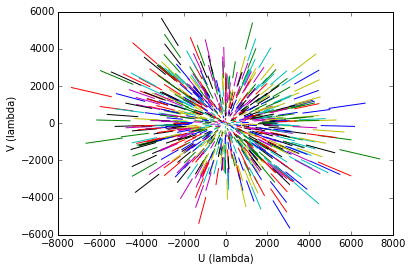

In [5]:
figure()
all_rlam = []
uvw = []
for ia1, a1 in enumerate(telnames):
    for ia2, a2 in enumerate(telnames[ia1+1:]):
        #u = [val[a1]['U (m)'] - val[a2]['U (m)'] for val in values]
        #v = [val[a1]['V (m)'] - val[a2]['V (m)'] for val in values]
        #w = [val[a1]['W (m)'] - val[a2]['W (m)'] for val in values]
        u = p[a1]['U (m)'] - p[a2]['U (m)']
        v = p[a1]['V (m)'] - p[a2]['V (m)']
        w = p[a1]['W (m)'] - p[a2]['W (m)']
        uvw.append((u,v,w))
        #print a1, a2, u, v, w
        ulam1, vlam1, wlam1 = u/lam1, v/lam1, w/lam1
        ulam2, vlam2, wlam2 = u/lam2, v/lam2, w/lam2
        r = np.sqrt(u*u + v*v)
        rlam1 = r/lam1
        rlam2 = r/lam2
        all_rlam.append((rlam1 - rlam2))
        plot([ulam1, ulam2], [vlam1, vlam2])
        plot([-ulam1, -ulam2], [-vlam1, -vlam2])

        
xlabel('U (lambda)')
ylabel('V (lambda)')
uvw = np.array(uvw)
uvwlam1 = uvw/lam1
uvwlam2 = uvw/lam2

In [6]:
assert(lam2 < lam1)

urange = uvwlam2[:, 0].max() - uvwlam2[:, 0].min()
vrange = uvwlam2[:, 1].max() - uvwlam2[:, 1].min()
lres = np.degrees(1.0/urange)*3600.
mres = np.degrees(1.0/vrange)*3600.
ucell = urange/float(Npix)*1.5
vcell = vrange/float(Npix)*1.5
size = np.degrees(1./ucell)
msize = np.degrees(1./vcell)
cellsize = min(ucell, vcell)

print('UV range={:0.1f}x{:0.1f} lambda = {:0.1f}x{:0.1f} arcsec FoV: {:0.2f}x{:0.2f} deg'.format(urange, vrange, lres, mres,cellsize, msize))

UV range=13345.7x9815.7 lambda = 15.5x21.0 arcsec FoV: 57.51x1.00 deg


31
(256, 1024)
8 7


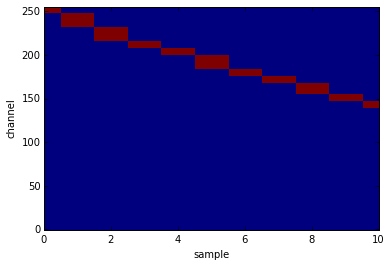

In [18]:
# make an FRB
#frb = np.zeros(Nchan, Nd)
target_dm=Nd-1
print(target_dm)
frb = np.zeros((Nchan, Nt))
frb = thefdmt.add_frb_track(target_dm, frb)
imshow(frb, aspect='auto', origin='lower', interpolation='nearest')
xlabel('sample')
ylabel('channel')
xlim(0, 10)
print(frb.shape)
print(nchanout, ndmout)
ntfrb = frb.shape[1]

(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
(32, 1024) 1024 32 32 1024
frbmax= 1.0 frbsum= 256.0 ddmax= 256.0
max S/N in each subband [32. 32. 32. 32. 32. 32. 32. 32.] 256.0


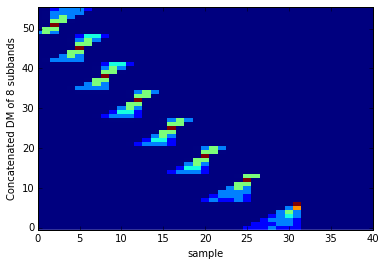

In [21]:
partial_fdmt = np.zeros((nchanout, ndmout, ntfrb+ndmout))
Nchan_partial = Nchan/nchanout
for cout in range(nchanout):
    pfdmt = fdmt.Fdmt(f1 + cout*Nchan_partial*chanbw, chanbw, Nchan_partial, ndmout, ntfrb)
    d = frb[cout*Nchan_partial:(cout+1)*Nchan_partial, :]
    print(d.shape, ntfrb, Nchan_partial, pfdmt.n_f, pfdmt.n_t)
    dout = pfdmt.execute(d)
    partial_fdmt[cout, :, :] = dout
    
imshow(partial_fdmt.reshape(nchanout*ndmout, -1), aspect='auto', origin='lower', interpolation='none')
xlim(0, 40)
xlabel('sample')
ylabel('Concatenated DM of 8 subbands')
frbdd = thefdmt.execute(frb)
print('frbmax=', frb.max(), 'frbsum=', frb.sum(), 'ddmax=', frbdd.max())
maxsub = partial_fdmt.max(axis=1).max(axis=1)
print('max S/N in each subband', maxsub, maxsub.sum())

In [22]:
# brute force dedisperse out to the desired DDM
#help(thefdmt.trace_dm)
#print(thefdmt.trace_dm(target_dm))
print(thefdmt.trace_dm(target_dm, final_iter=5))
maxpos = np.unravel_index(np.argmax(partial_fdmt.reshape(-1, np.array(partial_fdmt.shape[1:]).prod()), axis=1), partial_fdmt.shape[1:]) 
print(maxpos)

[(0, 6, 0), (1, 5, 6), (2, 4, 11), (3, 4, 15), (4, 4, 19), (5, 3, 23), (6, 3, 26), (7, 2, 29)]
(array([6, 5, 4, 4, 4, 3, 3, 2]), array([31, 25, 20, 16, 12,  8,  5,  2]))


256.0 31


(0, 50)

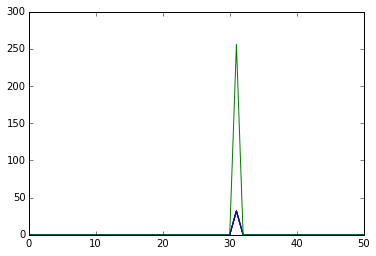

In [29]:
frbsum = np.zeros(partial_fdmt.shape[-1])
ftrace = thefdmt.trace_dm(target_dm,final_iter=5)
ftrace_idms = [f[1] for f in ftrace]
ftrace_offsets = [f[2] for f in ftrace]
for cout, (_, idm, ioff) in enumerate(ftrace):
    xroll = np.roll(partial_fdmt[cout, idm, :], ioff)
    plot(xroll)
    frbsum += xroll
    
plot(frbsum)
print(frbsum.max(), frbsum.argmax())
xlim(0,50)

[ 0.9059519   6.55934964 11.54718931 15.96998637 19.9099733  23.43494978
 26.60121906 29.45585034] 31
max offset 29.45585034028037


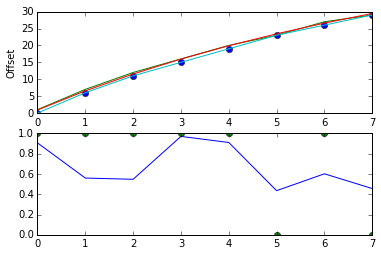

In [33]:
fig, ax = subplots(2,1)

ax[0].plot(aioff, 'o')
def offset_cff(thefdmt, cout):
    f1 = thefdmt.f_min+ cout*Nchan_partial*chanbw - 0.5*chanbw
    f2 = thefdmt.f_min+(cout+1)*Nchan_partial*chanbw
    fmid = (f1 + f2)/2.0 - 0.5*chanbw
    # Worked otu the rounding after a bit of efford - not tneirely sure it's right
    #dt = float(Nd -1)/float(Nd)- fdmt.cff(f1, thefdmt.f_max - 0.5*chanbw, thefdmt.f_min, thefdmt.f_max)
    # dt = fdmt.cff(thefdmt.f_min, f1, thefdmt.f_min, thefdmt.f_max) + 0.5/(Nd)
    dt = fdmt.cff(f1, thefdmt.f_min, thefdmt.f_max, thefdmt.f_min) + 0*0.5/(Nd) # need to add a bit extra. Not surewhy.
    
    #print thefdmt.f_min, thefdmt.f_max, f1, f2, dt
    return dt
    

calc_offsets = target_dm*np.array([offset_cff(thefdmt, cout) for cout in range(nchanout)]) + (target_dm+1)/Nd
ax[0].plot(np.round(calc_offsets))
ax[0].plot(calc_offsets)
ax[0].plot(ftrace_offsets)
print(calc_offsets, target_dm)
ax[0].set_xlabel('Subband')
ax[0].set_ylabel('Offset')

ax[1].plot(calc_offsets - ftrace_offsets)
ax[1].plot(np.round(calc_offsets) - ftrace_offsets, 'o')
print("max offset", calc_offsets.max())


1.0 0.125


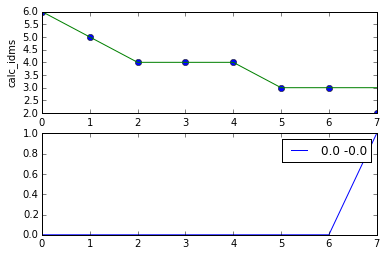

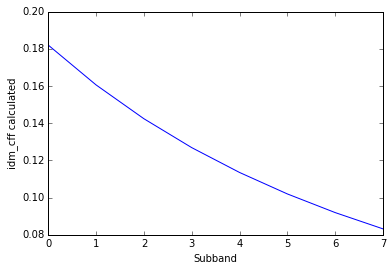

In [42]:
fig, ax = subplots(2,1)

ax[0].plot(aidm, 'o')

def idm_cff(thefdmt, cout, f1off=0, f2off=0):
    f1 = thefdmt.f_min+ cout*Nchan_partial*chanbw  + f1off*chanbw
    f2 = thefdmt.f_min+(cout+1)*Nchan_partial*chanbw  + f2off*chanbw
    fmid = (f1 + f2)/2.0 - 0.5*chanbw
    bandmid = (thefdmt.f_min + thefdmt.f_max)/2.0
    dt = fdmt.cff(f2, f1, thefdmt.f_max, thefdmt.f_min) 
    #print thefdmt.f_min, thefdmt.f_max, f1, f2, dt
    return dt
    
    
#for f1off in np.arange(-1,1.5,0.5):
#    for f2off in np.arange(-1, 1.5, 0.5):
#        print f1off, f2off
f1off = 0.5*0
f2off= -0.5*0
calc_idm_cff = np.array([idm_cff(thefdmt, cout) for cout in range(nchanout)])
calc_idms = np.round(target_dm*calc_idm_cff)
ax[0].plot(calc_idms)
#print(calc_idms)
ax[0].set_xlabel('Subband')
ax[0].set_ylabel('calc_idms')
err = calc_idms - ftrace_idms
ax[1].plot(err, label='%0.1f %0.1f' % (f1off, f2off))

print((err.max() - err.min()), err.mean())
#ax[1].set_ylim(-0.5, 0.5)
ax[1].legend()
figure()
plot(calc_idm_cff)
xlabel('Subband')
ylabel('idm_cff calculated')

0 5.0 0.9059518977025784
1 5.0 6.5593496359372105
2 4.0 11.54718931077198
3 4.0 15.969986372771135
4 3.0 19.909973303291444
5 3.0 23.434949777899217
6 3.0 26.601219062472175
7 2.0 29.45585034028037
232.0 31


(0, 10)

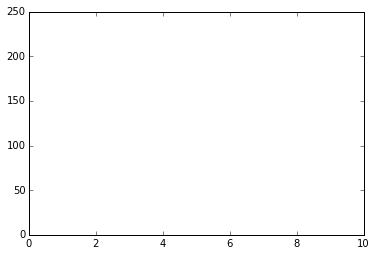

In [13]:
frbsum = np.zeros(partial_fdmt.shape[-1])

for cout, (idm, ioff) in enumerate(zip(calc_idms, calc_offsets)):
    print(cout, idm, ioff)
    xroll = np.roll(partial_fdmt[cout, int(idm), :], int(ioff))
    plot(xroll)
    frbsum += xroll
    
plot(frbsum)
print(frbsum.max(), frbsum.argmax())
xlim(0,10)

(0.7355, 0.7355)


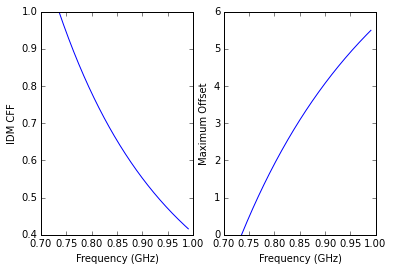

In [36]:
class Plan(object):
    def __init__(self):
        self.ncin = 32
        self.foff = 0.001
        self.fmin = f1
        self.fmax = f1 + self.ncin*self.foff
        self.nd = 186
        
plan = Plan()

print((f1, freqs[0]))

idm_cff    = np.array([craco_kernels.idm_cff(f, plan) for f in freqs])
offset_cff = np.array([craco_kernels.offset_cff(f, plan) for f in freqs])


fig, ax = subplots(1,2)
ax[0].plot(freqs, idm_cff)
#ax[0].plot(freqs, fdmt_cff_id1)

ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('IDM CFF')
ax[1].plot(freqs, offset_cff)
#ax[1].plot(freqs, fdmt_cff_off)

ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Maximum Offset')

    

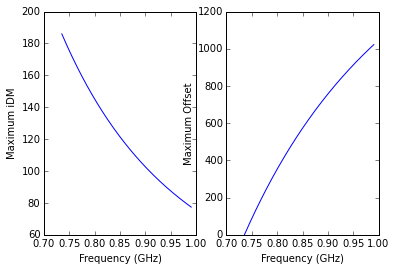

In [37]:
max_idm    = 186*idm_cff;
max_offset = 186*offset_cff

fig, ax = subplots(1,2)
ax[0].plot(freqs, max_idm)
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Maximum iDM')
ax[1].plot(freqs, max_offset)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Maximum Offset')

In [15]:
fdmt_cff_id1 = []
fdmt_cff_off = []

for fch1 in freqs:
    iterno=3
    planfdmt = fdmt.Fdmt(fch1, plan.foff, 32, 186, Nt)
    nfdat = planfdmt.hist_nf_data[iterno]
    cdata = nfdat[0]
    (f_start, f_end, f_middle, f_middle_larger, delta_t_local, idt_data) = cdata
    cff_id1 = fdmt.cff(f_middle, f_start, f_end, f_start)
    cff_off = fdmt.cff(f_middle_larger, f_start, f_end, f_start)
    #print(f_start, cff_id1, cff_off)
    
    fdmt_cff_id1.append(cff_id1)
    fdmt_cff_off.append(cff_off)
    


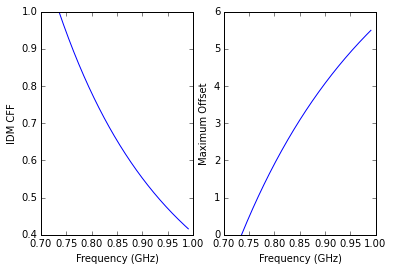